In [1]:
from datasets import load_dataset 
from IPython.display import display
from ipywidgets import widgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import torch
import time
from torch import optim
from torch.nn import functional as F
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

sns.set()

In [81]:
model_repo = 'google/mt5-small'
model_path = './mt5_translation_small.pt'
max_sequence_length = 20

In [82]:
tokenizer = AutoTokenizer.from_pretrained(model_repo)

In [83]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_repo)
model = model.cuda()

In [84]:
token_ids = tokenizer.encode(
    'This will be translated to Javanese, hopefully bruh',
    return_tensors='pt').cuda()
print(token_ids)

model_out = model.generate(token_ids)
print(model_out)

output_text = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(model_out[0]))
print(output_text)

tensor([[ 1494,   898,   390, 37194,   285,   288, 28816, 31995,   261, 10148,
         11994, 27090,   334,     1]], device='cuda:0')
tensor([[     0, 250099,    259,   1542,    339,      1]], device='cuda:0')
<pad> <extra_id_0> which is</s>


In [85]:
example_input_text = 'Aku akan berada di sini bersamamu'

input_ids = tokenizer.encode(example_input_text, return_tensors='pt')
print(input_ids)

tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
print(tokens)

tensor([[11585,  1481, 20273,   262,   301, 18212, 11565,  1179,     1]])
['▁Aku', '▁akan', '▁berad', 'a', '▁di', '▁sini', '▁bersama', 'mu', '</s>']


In [88]:
# LOADING THE DATASET
dataset_path = './final_dataset.txt'
dataset_raw = open(dataset_path, 'r', encoding='utf-8')
dataset_raw = dataset_raw.readlines()
translations = []
ids = []
for index, en_jv in enumerate(dataset_raw): 
  translations.append(eval(en_jv.strip()))
  ids.append(index)

In [89]:
# shuffle
dataset = pd.DataFrame({'id': ids, 'translation': translations})
dataset = dataset.sample(frac=1)
dataset

,id,translation
0,0,"{'en': 'Episode 1', 'jv': 'Episot Siji'}"
1,1,"{'en': 'Oh Ha Ni?', 'jv': 'Oh Ha Ni ?'}"
2,2,"{'en': 'Oh Ha Ni?!', 'jv': 'Oh Ha Ni ?'}"
3,3,"{'en': 'Yes?', 'jv': 'Injih ?'}"
4,4,{'en': 'What are you thinking about so early i...
...,...,...
33011,33011,"{'en': 'Stop!', 'jv': 'Mandheg!'}"
33012,33012,"{'en': 'Call the police!', 'jv': 'Undangna Pol..."
33013,33013,"{'en': 'Happy Birthday', 'jv': 'Sugeng Ambal W..."
33014,33014,"{'en': 'where is the toilet', 'jv': 'Jedhingé ..."


In [90]:
# split into train and test
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2)

In [91]:
train_dataset

,id,translation
22136,22136,"{'en': '""Son of man, take up a lamentation ove..."
3965,3965,{'en': 'and the priest shall look at him on th...
29819,29819,"{'en': 'Now, brethren, we wish to make known..."
13074,13074,"{'en': 'and to bring the silver and gold, whic..."
31631,31631,{'en': 'and I will give him the morning star.'...
...,...,...
31301,31301,"{'en': ' Act as free men, and do not use your..."
11238,11238,"{'en': 'Ephah, Caleb's concubine, bore Haran, ..."
32211,32211,"{'en': 'Yoruba', 'jv': 'Yoruba'}"
23396,23396,"{'en': '""I will also plant them on their land,..."


In [92]:
test_dataset

,id,translation
321,321,"{'en': 'Take an existing video on the web, sub..."
32428,32428,"{'en': '8 PM', 'jv': '8 bengi'}"
25589,25589,{'en': 'AND YOU SHALL LOVE THE LORD YOUR GOD W...
21484,21484,{'en': ''I will give it into the hands of the ...
27090,27090,"{'en': 'So Jesus said to him, ""Unless you peo..."
...,...,...
27934,27934,{'en': ''THE KINGS OF THE EARTH TOOK THEIR STA...
31237,31237,{'en': 'Yet you do not know what your life wil...
25486,25486,{'en': 'and if she herself divorces her husban...
17799,17799,{'en': 'Before destruction the heart of man is...


In [93]:
# add custom language tokens to determine the translation, whether it is from englist to java or vice versa
languages_mapping = {
    'en': '<en>',
    'jv': '<jv>'
}

In [94]:
# append the tokens to the tokenizer and model
special_tokens_dict = {'additional_special_tokens': list(languages_mapping.values())}
tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

Embedding(250102, 768)

In [95]:
# test the tokenizer
example_string = "Kowe aja padha lali aweh pamondhokan marang wong"
token_ids = tokenizer.encode(
    example_string, return_tensors='pt', padding='max_length',
    truncation = True, max_length=max_sequence_length)
print(token_ids)

tokens = tokenizer.convert_ids_to_tokens(token_ids[0])
print(tokens)

tensor([[   412,   3407,  19454,    555,  16084,    283,    494,    259,    262,
         135150,    555,  14738,   1036,    502,    259,  64871,    259,  36711,
              1,      0]])
['▁K', 'owe', '▁aja', '▁pa', 'dha', '▁la', 'li', '▁', 'a', 'weh', '▁pa', 'mond', 'ho', 'kan', '▁', 'marang', '▁', 'wong', '</s>', '<pad>']


In [99]:
def encode_input_str(text, target_language, tokenizer, sequence_length, lang_mapping=languages_mapping):
    target_lang_token = lang_mapping[target_language]

    # tokenize
    input_ids = tokenizer.encode(
      text = target_lang_token + text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True, # max 20 sequence, model limitation
      max_length = sequence_length
    )

    return input_ids[0]

def encode_target_str(text, tokenizer, sequence_length):
    token_ids = tokenizer.encode(
      text = text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True, # max 20 sequence, model limitation
      max_length = sequence_length
    )

    return token_ids[0]

def format_translation_data(translations, tokenizer, sequence_length, lang_mapping=languages_mapping):
    # Choose randomly between en or jv as input and target languages
    languages = list(lang_mapping.keys())
    input_language, target_language = np.random.choice(languages, size=2, replace=False)

    # Get translations for the batch
    input_text = translations[input_language]
    target_text = translations[target_language]

    if input_text is None or target_text is None: 
        return None

    input_token_ids = encode_input_str(
    input_text, target_language, tokenizer, sequence_length)

    target_token_ids = encode_target_str(
    target_text, tokenizer, sequence_length)

    return input_token_ids, target_token_ids

def transform_batch(batch, tokenizer):
    inputs = []
    targets = []
    for translations_set in batch['translation']:
        formatted_data = format_translation_data(translations_set, tokenizer, max_sequence_length)

        if formatted_data is None: 
            continue

        input_lang_ids, target_lang_ids = formatted_data
        inputs.append(input_lang_ids.unsqueeze(0))
        targets.append(target_lang_ids.unsqueeze(0))
        # print(input_lang_ids)
        # print(target_lang_ids)
        # break

    batch_input_ids = torch.cat(inputs).cuda()
    batch_target_ids = torch.cat(targets).cuda()

    return batch_input_ids, batch_target_ids

def get_data_generator(dataset, tokenizer, batch_size=32):
    dataset = dataset.sample(frac=1)
    for i in range(0, len(dataset), batch_size):
        raw_batch = dataset[i:i+batch_size]
        yield transform_batch(raw_batch, tokenizer)

In [100]:
train_dataset['translation']

22136    {'en': '"Son of man, take up a lamentation ove...
3965     {'en': 'and the priest shall look at him on th...
29819    {'en': 'Now, brethren, we  wish to  make known...
13074    {'en': 'and to bring the silver and gold, whic...
31631    {'en': 'and I will give him the morning star.'...
                               ...                        
31301    {'en': ' Act  as free men, and do not use your...
11238    {'en': 'Ephah, Caleb's concubine, bore Haran, ...
32211                     {'en': 'Yoruba', 'jv': 'Yoruba'}
23396    {'en': '"I will also plant them on their land,...
18004    {'en': 'Take away the wicked before the king, ...
Name: translation, Length: 26412, dtype: object

In [101]:
# test the dataset format
random_pick_testing = test_dataset.sample()['translation']
testing = random_pick_testing[random_pick_testing.keys()[0]]
testing

{'en': '"When a garment has a mark of leprosy in it, whether it is a wool garment or a linen garment,',
 'jv': 'Manawa ana sandhangan kang ana tandha-tandhane memala saraat, dadia sandhangan wol utawa lena,'}

In [102]:
# Testing 'data_transform'
print(testing)
in_ids, out_ids = format_translation_data(testing, tokenizer, max_sequence_length)

print(' '.join(tokenizer.convert_ids_to_tokens(in_ids)))
print(' '.join(tokenizer.convert_ids_to_tokens(out_ids)))

# Testing data generator
data_gen = get_data_generator(train_dataset, tokenizer, 8)
data_batch = next(data_gen)
print('input shape:', data_batch[0].shape)
print('output shape:', data_batch[1].shape)

{'en': '"When a garment has a mark of leprosy in it, whether it is a wool garment or a linen garment,', 'jv': 'Manawa ana sandhangan kang ana tandha-tandhane memala saraat, dadia sandhangan wol utawa lena,'}
<jv> ▁" When ▁ a ▁gar ment ▁has ▁ a ▁mark ▁of ▁le pros y ▁in ▁it , ▁w </s>
▁Man awa ▁ana ▁sand hang an ▁kang ▁ana ▁tand ha - t and hane ▁mem ala ▁sara at , </s>
input shape: torch.Size([8, 20])
output shape: torch.Size([8, 20])


In [104]:
# Constants
n_epochs = 30
batch_size = 4
print_frequency = 200
checkpoint_frequency = 700
learning_rate = 5e-4
n_batches = int(np.ceil(len(train_dataset) / batch_size))
total_steps = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01)

In [105]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)
scheduler = get_linear_schedule_with_warmup(optimizer, n_warmup_steps, total_steps)

In [106]:
# losses for graphing
losses = []
losses_train = []
losses_test_temp = []
losses_test = []
exec_times = []

In [107]:
# evaluate the model (test loss)
def eval_model(model, gdataset, max_iters=8):
    test_generator = get_data_generator(gdataset, tokenizer, batch_size)
    eval_losses = []
    for i, (input_batch, label_batch) in enumerate(test_generator):
        if i >= max_iters:
            break

        model_out = model.forward(input_ids=input_batch, labels=label_batch)
        eval_losses.append(model_out.loss.item())

        return np.mean(eval_losses)

In [108]:
for epoch_index in range(n_epochs):
    # Init start time to calculate exec time
    start_time = time.time()
    
    # Reset the loss list
    losses.clear()
    losses_test_temp.clear()
    
    # Randomize data order
    data_generator = get_data_generator(train_dataset, tokenizer, batch_size)
  
    for batch_index, (input_batch, label_batch) in tqdm_notebook(enumerate(data_generator), total=n_batches):
        optimizer.zero_grad()

        # Forward pass
        model_out = model.forward(input_ids=input_batch, labels=label_batch)

        # Calculate loss and update weights
        loss = model_out.loss
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print training update info
        if (batch_index + 1) % print_frequency == 0:
            avg_loss = np.mean(losses[-print_frequency:])
            exec_time = time.time() - start_time
            print('Epoch: {} | Step: {} | Avg. loss: {:.3f} | Lr: {} | Exec. time: {:.1f}'.format(
                  epoch_index + 1, batch_index + 1, avg_loss, scheduler.get_last_lr()[0], exec_time))
      
        if (batch_index + 1) % checkpoint_frequency == 0: 
            test_loss = eval_model(model, test_dataset)
            print('Saving model with test loss of {:.3f}'.format(test_loss))
            losses_test_temp.append(test_loss)
            torch.save(model.state_dict(), model_path)
        
        if (batch_index + 1) == n_batches:
            losses_train.append(np.mean(losses))
            test_loss = eval_model(model, test_dataset)
            print("Final test loss = ", test_loss)
            losses_test_temp.append(test_loss)
            losses_test.append(np.mean(losses_test_temp))
            exec_time = time.time() - start_time
            exec_times.append(exec_time)
            print(f"Epoch {epoch_index + 1} done, avg. loss: {losses_train[-1]:.3f},"
                  f"avg. test loss: {losses_test[-1]:.3f}, exec.time: {exec_time:.1f}")

torch.save(model.state_dict(), model_path)

/tmp/ipykernel_2126008/2210750613.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_index, (input_batch, label_batch) in tqdm_notebook(enumerate(data_generator), total=n_batches):


Epoch: 1 | Step: 50 | Avg. loss: 14.017 | Lr: 0.00011363636363636362 | Exec. time: 9.4
Epoch: 1 | Step: 100 | Avg. loss: 8.296 | Lr: 0.00022727272727272725 | Exec. time: 19.0
Epoch: 1 | Step: 150 | Avg. loss: 6.084 | Lr: 0.00029958702967268274 | Exec. time: 28.6
Epoch: 1 | Step: 200 | Avg. loss: 5.194 | Lr: 0.00029843988987457936 | Exec. time: 38.3
Epoch: 1 | Step: 250 | Avg. loss: 4.446 | Lr: 0.00029729275007647597 | Exec. time: 47.9
Epoch: 1 | Step: 300 | Avg. loss: 3.979 | Lr: 0.0002961456102783726 | Exec. time: 57.7
Epoch: 1 | Step: 350 | Avg. loss: 3.763 | Lr: 0.00029499847048026915 | Exec. time: 67.5
Epoch: 1 | Step: 400 | Avg. loss: 3.574 | Lr: 0.00029385133068216576 | Exec. time: 77.4
Epoch: 1 | Step: 450 | Avg. loss: 3.479 | Lr: 0.0002927041908840624 | Exec. time: 87.1
Epoch: 1 | Step: 500 | Avg. loss: 3.468 | Lr: 0.000291557051085959 | Exec. time: 96.9
Saving model with test loss of 3.423
Epoch: 1 | Step: 550 | Avg. loss: 3.387 | Lr: 0.0002904099112878556 | Exec. time: 109.2


Epoch: 2 | Step: 50 | Avg. loss: 2.452 | Lr: 0.00026400275313551543 | Exec. time: 340.2
Epoch: 2 | Step: 100 | Avg. loss: 2.530 | Lr: 0.00026285561333741204 | Exec. time: 350.0
Epoch: 2 | Step: 150 | Avg. loss: 2.449 | Lr: 0.00026170847353930866 | Exec. time: 359.9
Epoch: 2 | Step: 200 | Avg. loss: 2.459 | Lr: 0.0002605613337412052 | Exec. time: 369.7
Epoch: 2 | Step: 250 | Avg. loss: 2.386 | Lr: 0.00025941419394310183 | Exec. time: 379.4
Epoch: 2 | Step: 300 | Avg. loss: 2.444 | Lr: 0.00025826705414499845 | Exec. time: 389.2
Epoch: 2 | Step: 350 | Avg. loss: 2.370 | Lr: 0.00025711991434689506 | Exec. time: 399.0
Epoch: 2 | Step: 400 | Avg. loss: 2.348 | Lr: 0.0002559727745487916 | Exec. time: 408.8
Epoch: 2 | Step: 450 | Avg. loss: 2.413 | Lr: 0.0002548256347506883 | Exec. time: 418.5
Epoch: 2 | Step: 500 | Avg. loss: 2.352 | Lr: 0.00025367849495258485 | Exec. time: 428.3
Saving model with test loss of 2.385
Epoch: 2 | Step: 550 | Avg. loss: 2.376 | Lr: 0.00025253135515448147 | Exec. 

Epoch: 3 | Step: 50 | Avg. loss: 1.979 | Lr: 0.00022612419700214132 | Exec. time: 672.2
Epoch: 3 | Step: 100 | Avg. loss: 2.044 | Lr: 0.0002249770572040379 | Exec. time: 681.9
Epoch: 3 | Step: 150 | Avg. loss: 2.057 | Lr: 0.00022382991740593452 | Exec. time: 691.7
Epoch: 3 | Step: 200 | Avg. loss: 1.986 | Lr: 0.0002226827776078311 | Exec. time: 701.5
Epoch: 3 | Step: 250 | Avg. loss: 2.068 | Lr: 0.00022153563780972772 | Exec. time: 711.3
Epoch: 3 | Step: 300 | Avg. loss: 2.001 | Lr: 0.0002203884980116243 | Exec. time: 721.1
Epoch: 3 | Step: 350 | Avg. loss: 2.000 | Lr: 0.00021924135821352092 | Exec. time: 730.8
Epoch: 3 | Step: 400 | Avg. loss: 1.976 | Lr: 0.00021809421841541756 | Exec. time: 740.6
Epoch: 3 | Step: 450 | Avg. loss: 1.986 | Lr: 0.00021694707861731415 | Exec. time: 750.4
Epoch: 3 | Step: 500 | Avg. loss: 2.054 | Lr: 0.00021579993881921077 | Exec. time: 760.1
Saving model with test loss of 2.429
Epoch: 3 | Step: 550 | Avg. loss: 1.972 | Lr: 0.00021465279902110735 | Exec. 

Epoch: 4 | Step: 50 | Avg. loss: 1.670 | Lr: 0.00018824564086876718 | Exec. time: 1003.4
Epoch: 4 | Step: 100 | Avg. loss: 1.699 | Lr: 0.00018709850107066382 | Exec. time: 1013.3
Epoch: 4 | Step: 150 | Avg. loss: 1.745 | Lr: 0.0001859513612725604 | Exec. time: 1023.1
Epoch: 4 | Step: 200 | Avg. loss: 1.724 | Lr: 0.00018480422147445702 | Exec. time: 1033.0
Epoch: 4 | Step: 250 | Avg. loss: 1.752 | Lr: 0.0001836570816763536 | Exec. time: 1042.7
Epoch: 4 | Step: 300 | Avg. loss: 1.777 | Lr: 0.00018250994187825022 | Exec. time: 1052.5
Epoch: 4 | Step: 350 | Avg. loss: 1.725 | Lr: 0.0001813628020801468 | Exec. time: 1062.3
Epoch: 4 | Step: 400 | Avg. loss: 1.731 | Lr: 0.00018021566228204342 | Exec. time: 1072.0
Epoch: 4 | Step: 450 | Avg. loss: 1.734 | Lr: 0.00017906852248394 | Exec. time: 1081.8
Epoch: 4 | Step: 500 | Avg. loss: 1.720 | Lr: 0.00017792138268583663 | Exec. time: 1091.6
Saving model with test loss of 2.229
Epoch: 4 | Step: 550 | Avg. loss: 1.804 | Lr: 0.00017677424288773324 |

Epoch: 5 | Step: 50 | Avg. loss: 1.537 | Lr: 0.00015036708473539306 | Exec. time: 1335.0
Epoch: 5 | Step: 100 | Avg. loss: 1.523 | Lr: 0.00014921994493728968 | Exec. time: 1344.8
Epoch: 5 | Step: 150 | Avg. loss: 1.512 | Lr: 0.0001480728051391863 | Exec. time: 1354.6
Epoch: 5 | Step: 200 | Avg. loss: 1.483 | Lr: 0.00014692566534108288 | Exec. time: 1364.4
Epoch: 5 | Step: 250 | Avg. loss: 1.515 | Lr: 0.0001457785255429795 | Exec. time: 1374.2
Epoch: 5 | Step: 300 | Avg. loss: 1.490 | Lr: 0.00014463138574487608 | Exec. time: 1384.0
Epoch: 5 | Step: 350 | Avg. loss: 1.573 | Lr: 0.0001434842459467727 | Exec. time: 1393.7
Epoch: 5 | Step: 400 | Avg. loss: 1.506 | Lr: 0.0001423371061486693 | Exec. time: 1403.6
Epoch: 5 | Step: 450 | Avg. loss: 1.510 | Lr: 0.0001411899663505659 | Exec. time: 1413.4
Epoch: 5 | Step: 500 | Avg. loss: 1.493 | Lr: 0.0001400428265524625 | Exec. time: 1423.2
Saving model with test loss of 2.063
Epoch: 5 | Step: 550 | Avg. loss: 1.543 | Lr: 0.00013889568675435913 |

Epoch: 6 | Step: 50 | Avg. loss: 1.334 | Lr: 0.00011248852860201895 | Exec. time: 1666.8
Epoch: 6 | Step: 100 | Avg. loss: 1.326 | Lr: 0.00011134138880391555 | Exec. time: 1676.6
Epoch: 6 | Step: 150 | Avg. loss: 1.322 | Lr: 0.00011019424900581215 | Exec. time: 1686.4
Epoch: 6 | Step: 200 | Avg. loss: 1.339 | Lr: 0.00010904710920770878 | Exec. time: 1696.3
Epoch: 6 | Step: 250 | Avg. loss: 1.316 | Lr: 0.00010789996940960538 | Exec. time: 1706.1
Epoch: 6 | Step: 300 | Avg. loss: 1.346 | Lr: 0.00010675282961150198 | Exec. time: 1715.8
Epoch: 6 | Step: 350 | Avg. loss: 1.320 | Lr: 0.00010560568981339858 | Exec. time: 1725.7
Epoch: 6 | Step: 400 | Avg. loss: 1.269 | Lr: 0.00010445855001529519 | Exec. time: 1735.4
Epoch: 6 | Step: 450 | Avg. loss: 1.320 | Lr: 0.00010331141021719179 | Exec. time: 1745.2
Epoch: 6 | Step: 500 | Avg. loss: 1.304 | Lr: 0.0001021642704190884 | Exec. time: 1755.0
Saving model with test loss of 2.307
Epoch: 6 | Step: 550 | Avg. loss: 1.282 | Lr: 0.00010101713062098

Epoch: 7 | Step: 50 | Avg. loss: 1.143 | Lr: 7.460997246864484e-05 | Exec. time: 1999.1
Epoch: 7 | Step: 100 | Avg. loss: 1.092 | Lr: 7.346283267054144e-05 | Exec. time: 2008.8
Epoch: 7 | Step: 150 | Avg. loss: 1.140 | Lr: 7.231569287243804e-05 | Exec. time: 2018.6
Epoch: 7 | Step: 200 | Avg. loss: 1.170 | Lr: 7.116855307433466e-05 | Exec. time: 2028.4
Epoch: 7 | Step: 250 | Avg. loss: 1.195 | Lr: 7.002141327623126e-05 | Exec. time: 2038.2
Epoch: 7 | Step: 300 | Avg. loss: 1.102 | Lr: 6.887427347812787e-05 | Exec. time: 2047.9
Epoch: 7 | Step: 350 | Avg. loss: 1.133 | Lr: 6.772713368002447e-05 | Exec. time: 2057.7
Epoch: 7 | Step: 400 | Avg. loss: 1.139 | Lr: 6.657999388192107e-05 | Exec. time: 2067.5
Epoch: 7 | Step: 450 | Avg. loss: 1.169 | Lr: 6.543285408381767e-05 | Exec. time: 2077.3
Epoch: 7 | Step: 500 | Avg. loss: 1.125 | Lr: 6.428571428571427e-05 | Exec. time: 2087.1
Saving model with test loss of 2.037
Epoch: 7 | Step: 550 | Avg. loss: 1.141 | Lr: 6.313857448761089e-05 | Exec

Epoch: 8 | Step: 50 | Avg. loss: 0.986 | Lr: 3.673141633527072e-05 | Exec. time: 2330.9
Epoch: 8 | Step: 100 | Avg. loss: 0.967 | Lr: 3.558427653716733e-05 | Exec. time: 2340.6
Epoch: 8 | Step: 150 | Avg. loss: 0.933 | Lr: 3.4437136739063935e-05 | Exec. time: 2350.4
Epoch: 8 | Step: 200 | Avg. loss: 0.948 | Lr: 3.3289996940960536e-05 | Exec. time: 2360.3
Epoch: 8 | Step: 250 | Avg. loss: 0.958 | Lr: 3.214285714285714e-05 | Exec. time: 2370.0
Epoch: 8 | Step: 300 | Avg. loss: 0.932 | Lr: 3.0995717344753745e-05 | Exec. time: 2379.8
Epoch: 8 | Step: 350 | Avg. loss: 0.961 | Lr: 2.984857754665035e-05 | Exec. time: 2389.5
Epoch: 8 | Step: 400 | Avg. loss: 0.975 | Lr: 2.8701437748546957e-05 | Exec. time: 2399.3
Epoch: 8 | Step: 450 | Avg. loss: 0.982 | Lr: 2.7554297950443557e-05 | Exec. time: 2409.1
Epoch: 8 | Step: 500 | Avg. loss: 0.969 | Lr: 2.640715815234016e-05 | Exec. time: 2418.9
Saving model with test loss of 1.998
Epoch: 8 | Step: 550 | Avg. loss: 0.888 | Lr: 2.526001835423677e-05 |

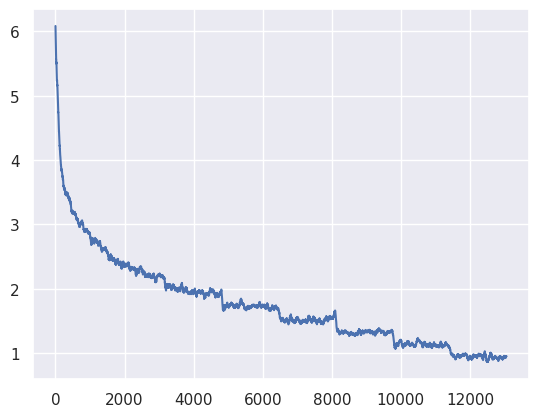

In [109]:
# Graph the loss 

window_size = 50
smoothed_loss = []
for i in range(len(losses)-window_size):
    smoothed_loss.append(np.mean(losses[i:i+window_size]))

plt.plot(smoothed_loss[100:])

In [ ]:
# train and test loss in one graph

x = [i for i in range(len(losses_train))]
plt.plot(x, losses_train, 'b', x, losses_test, 'r')
plt.xticks(x)
plt.legend(['Train loss', 'Test loss'])
plt.title(f"epochs: {len(losses_train)}, batch: {batch_size}, lr: {learning_rate}, exec. time: {np.sum(exec_times):.1f}")
plt.rcParams["figure.figsize"] = (10, 5)

### Manual testing

In [110]:
# test random index pick
test_dataset.sample()['translation'].keys()[0]

26046

In [192]:
# test the translation
random_pick = test_dataset.sample()['translation']
test_sentence = random_pick[random_pick.keys()[0]]['en']
test_sentence = 'my name is karel, i live in kentucky, united states of america'
print('Raw input text:', test_sentence)

input_ids = encode_input_str(
    text = test_sentence,
    target_language='jv',
    tokenizer=tokenizer,
    sequence_length=model.config.max_length,
    lang_mapping=languages_mapping,
)
input_ids = input_ids.unsqueeze(0).cuda()

print('Truncated input:', tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[0])
))

Raw input text: my name is karel, i live in kentucky, united states of america
Truncated input: <jv> my name is karel, i live in kentucky, united states</s>


In [193]:
# translation output
output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=10)
for token_set in output_tokens:
    print(tokenizer.decode(token_set, skip_special_tokens=True))

Nami kula karel, kula manggen wonten ing kentu, ing 
Nami kula karel, i biyen manggen wonten ing kentu 
Nami kula karel, kula manggen wonten ing kentu ing tanah
Nami kula karel, i biyen manggen wonten ing kentu,
Nami kula karel, kula manggen wonten ing kentu ing wong
Nami kula karel, kula manggen wonten ing kentu, ing negara
Nami kula karel, kula manggen wonten ing kentu ing nagara
Nami kula karel, kula rumeksa ing kentu ing tanah
Nami kula karel, kula manggen wonten ing kutha kentu ing
Nami kula karel, kula manggen wonten ing kentu, ing wil
